In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2



In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 30


In [3]:
DIRECTORY = "/kaggle/input/mrl-dataset/train"
CATEGORIES = ["Closed_Eyes", "Open_Eyes"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

[INFO] loading images...


In [4]:
DIRECTORY_TEST = "/kaggle/input/eyes-open-or-closed/dataset/test"
CATEGORIES = ["Closed_Eyes", "Open_Eyes"]
testX = []
testY = []
for category in CATEGORIES:
    path = os.path.join(DIRECTORY_TEST, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        testX.append(image)
        testY.append(category)


In [5]:
print(len(data))
print(len(labels))
print(len(testX))
print(len(testY))

4000
4000
600
600


In [6]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)



data = np.array(data, dtype="float32")
labels = np.array(labels)




In [7]:
testY = lb.fit_transform(testY)
testY = to_categorical(testY)

testX = np.array(testX, dtype="float32")
testY = np.array(testY)

In [8]:
#data[0]


In [9]:
#labels

In [10]:
(trainX, validX, trainY, validY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [11]:
validY

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [12]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))



baseModel.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [13]:
len(baseModel.layers)

154

In [14]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers[:65]:
    layer.trainable = False
for layer in baseModel.layers[65:]:
    layer.trainable = True
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(validX, validY),
    validation_steps=len(validX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
106/106 [==============================] - 44s 331ms/step - loss: 0.2551 - accuracy: 0.9040 - val_loss: 0.4626 - val_accuracy: 0.7350
Epoch 2/10
106/106 [==============================] - 33s 315ms/step - loss: 0.0069 - accuracy: 0.9995 - val_loss: 0.0512 - val_accuracy: 0.9937
Epoch 3/10
106/106 [==============================] - 33s 311ms/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.0275 - val_accuracy: 0.9962
Epoch 4/10
106/106 [==============================] - 33s 315ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 0.9975
Epoch 5/10
106/106 [==============================] - 33s 315ms/step - loss: 5.7097e-04 - accuracy: 1.0000 - val_loss: 0.0379 - val_accuracy: 0.9962
Epoch 6/10
106/106 [==============================] - 33s 314ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 7.4302e-04 - val_accuracy: 1.0000
Epoch 7/10
106/106 [==============================] - 33s 313ms/step - l

In [15]:
validY

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [16]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving model...")
model.save("CloseOrOpenEye.model", save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

 Closed_Eyes       1.00      1.00      1.00       240
   Open_Eyes       1.00      1.00      1.00       360

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

[INFO] saving model...


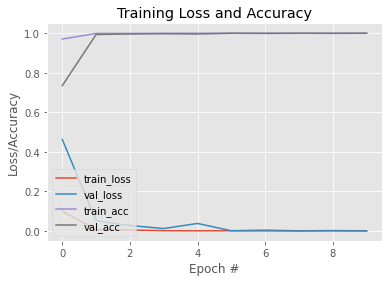

In [17]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

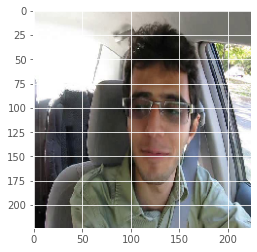

[[0.03082149 0.94769675]]
[1]
Open


In [18]:
path = "/kaggle/input/yawn-eye-dataset-new/dataset_new/test/no_yawn/2354.jpg"

image = load_img(path, target_size=(224, 224))
plt.imshow(image)
plt.show()
image = img_to_array(image)
image = np.expand_dims(image, axis = 0)

imge = preprocess_input(image)
    
prediction = model.predict(image,BS)
print(prediction)
i = 0
#predIdxs = model.predict(image, batch_size=BS)
predIdxs = np.argmax(prediction, axis=1)
print(predIdxs)
if predIdxs[0] == 0 :
    prediction_class = 'Closed'

else :
    prediction_class = 'Open'

print(prediction_class)



In [19]:
len(testX)

600

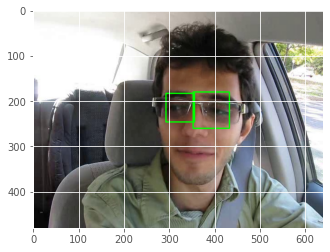

[[0.0575808 0.9002161]]
[1]
Open


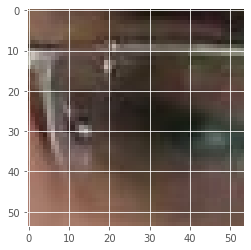

In [20]:
img= '/kaggle/input/yawn-eye-dataset-new/dataset_new/test/no_yawn/2354.jpg'
img = cv2.imread(img)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
gray = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)#converting the input image to greay image
face_cascade = cv2.CascadeClassifier('../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('../input/haar-cascades-for-face-detection/haarcascade_eye.xml')
eyes = eye_cascade.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)
for x,y,w,h in eyes:
    cv2.rectangle(img,(x,y),(x+w ,y+h), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
for x,y,w,h in eyes:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyess = eye_cascade.detectMultiScale(roi_gray)
    if len(eyess) == 0:
        print("eyes are not detected")
    else:
        for(ex,ey,ew,eh) in eyess:
            eyes_roi = roi_color[ey: ey+eh, ex:ex+ew]
plt.imshow(cv2.cvtColor(eyes_roi, cv2.COLOR_BGR2RGB))
eyes_roi.shape
final_image = cv2.resize(eyes_roi,(224,224))
#final_image = img_to_array(final_image)
#final_image = np.reshape(224,224)
final_image = np.expand_dims(final_image, axis = 0)

final_image = preprocess_input(final_image)
    
prediction = model.predict(final_image,BS)
print(prediction)
#i = 0
#predIdxs = model.predict(image, batch_size=BS)
predIdxs = np.argmax(prediction, axis=1)
print(predIdxs)
if predIdxs[0] == 0 :
    prediction_class = 'Closed'

else :
    prediction_class = 'Open'

print(prediction_class)

In [21]:
img= '/kaggle/input/yawn-eye-dataset-new/dataset_new/test/no_yawn/2354.jpg'
img = cv2.imread(img)


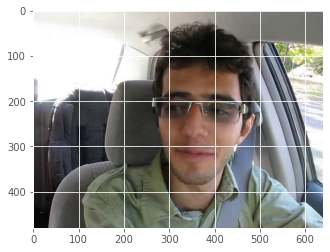

In [22]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [23]:
gray = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)#converting the input image to greay image

In [24]:
face_cascade = cv2.CascadeClassifier('../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')

In [25]:
eye_cascade = cv2.CascadeClassifier('../input/haar-cascades-for-face-detection/haarcascade_eye.xml')

In [26]:
eyes = eye_cascade.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

In [27]:
for x,y,w,h in eyes:
    cv2.rectangle(img,(x,y),(x+w ,y+h), (0, 255, 0), 2)

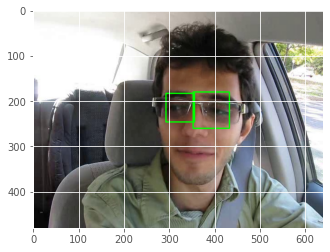

In [28]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [29]:
for x,y,w,h in eyes:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyess = eye_cascade.detectMultiScale(roi_gray)
    if len(eyess) == 0:
        print("eyes are not detected")
    else:
        for(ex,ey,ew,eh) in eyess:
            eyes_roi = roi_color[ey: ey+eh, ex:ex+ew]
    

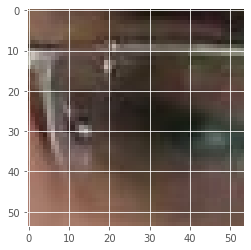

In [30]:
plt.imshow(cv2.cvtColor(eyes_roi, cv2.COLOR_BGR2RGB))

In [31]:
eyes_roi.shape

(54, 54, 3)

In [32]:
final_image = cv2.resize(eyes_roi,(224,224))
#final_image = np.expand_dims(final_image, axis = 0)
#final_image = final_image/255.0

In [33]:
#final_image = img_to_array(final_image)
#final_image = np.reshape(224,224)
final_image = np.expand_dims(final_image, axis = 0)

final_image = preprocess_input(final_image)
    
prediction = model.predict(final_image,BS)
print(prediction)
#i = 0
#predIdxs = model.predict(image, batch_size=BS)
predIdxs = np.argmax(prediction, axis=1)
print(predIdxs)
if predIdxs[0] == 0 :
    prediction_class = 'Closed'

else :
    prediction_class = 'Open'

print(prediction_class)

[[0.0575808 0.9002161]]
[1]
Open


In [34]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')